# MA(1) Signal with Additive White Noise

Here we import nessessary packages 

In [1]:
using Polynomials
using DSP
using Plots
using StatsBase
pyplot()

include("wiener_filter_scalar_fft.jl")

include("../../Model_Reduction_Dev.jl")

vector_wiener_filter_fft

The parameters for this model are defined here.

In [2]:
r = 5
sig_v = 3

3

## A Theoretical Solution

All the details for he formulation of `h_ana` are given in the Wiener Filtering Tutorial.

In [8]:
rho_poly = Polynomial([1, -(1 + r^2 + sig_v^2)/r, 1])

rhos = roots(rho_poly)

rho = rhos[ abs.(rhos) .< 1][1]

M_h = 50
h_temp = [-sig_v^2/r*rho^(n+1) for n = 1 : M_h - 1]
h_ana = [1-sig_v^2/r*rho; h_temp];

## Data and Numerical Solution

In [9]:
w = [1, -r];

Here we generate the data

In [10]:
steps = 1*10^6
discard = 10^4
steps_tot = steps + discard

noise_sig = randn(steps_tot)
w = [1, -r];
sig = conv(w,noise_sig)[discard + 1 : steps_tot];

noise_pred = sig_v*randn(steps)
pred = sig .+ noise_pred;

Now we call the program I wrote to Numerically solve the Weiner filter. 

In [11]:
h_num_fft = wiener_filter_fft(pred, sig,par = 30);

In [12]:
sig_vec = reshape(sig,1,:)
pred_vec = reshape(pred,1,:)

h_num_mat = vector_wiener_filter_fft(
    sig_vec,
    pred_vec,
    M_h;
    par = 2000,
    win = "Par",
    n = 3,
    p = 1500,
    PI = true,
    rtol = 1e-6
    )

h_num = real(reshape(h_num_mat,:));

Now to verify the preformance.

error_num = 6.628664465997885
error_ana = 6.6289582055747625

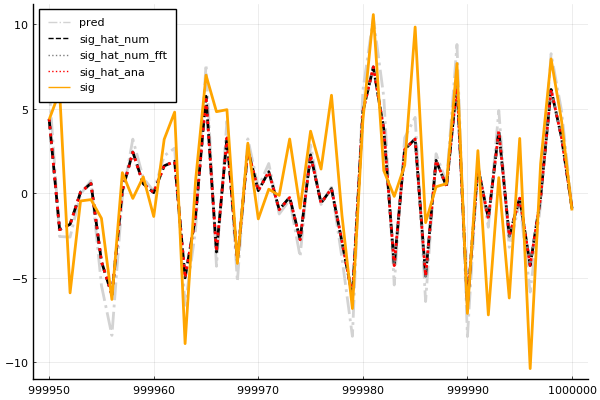

In [13]:
sig_hat_num_fft = conv(real.(h_num_fft),pred)[1:steps]
sig_hat_num = conv(real.(h_num),pred)[1:steps]
sig_hat_ana = conv(real.(h_ana),pred)[1:steps]

view = 50
start = steps - view
tim = start:start + view;
error_num = sum((sig .- sig_hat_num).^2)/steps;
error_ana = sum((sig .- sig_hat_ana).^2)/steps;

print("error_num = ",error_num,"\n")
print("error_ana = ",error_ana)

plot(tim,[pred[tim] sig_hat_num[tim] sig_hat_num_fft[tim] sig_hat_ana[tim] sig[tim]],
    color=[:lightgrey :black :gray :red :orange ], 
    line=(2,[:dashdot :dash :dot :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

In [14]:
1 - sig_v^2/r*rho - (1+r^2)/r*rho + rho^2
# 1 - (1+r^2 +sig_v^2)/r*rho + rho^2

-7.979727989493313e-17

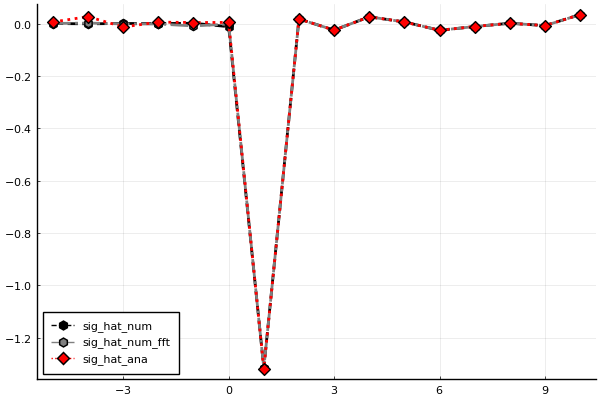

In [15]:
error_num_fft = sig .-sig_hat_num_fft
error_num = sig .-sig_hat_num
error_ana = sig .-sig_hat_ana
lags = -5:10
C_ana = crosscov(error_ana,pred,lags)
C_num = crosscov(error_num,pred,lags)
C_num_fft = crosscov(error_num_fft,pred,lags)
plot(lags, [C_num C_num_fft C_ana],
    color=[:black :grey :red],
    line=(2,[:dash :dashdot :dot]),
    label=["sig_hat_num" "sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :hex :d],6))

(-0.00023342971813943193, 0.00022612744406362396)
(-0.00019487396609553983, 0.0002337348606720038)
(-0.0001675562312847403, 0.00023593964804639067)

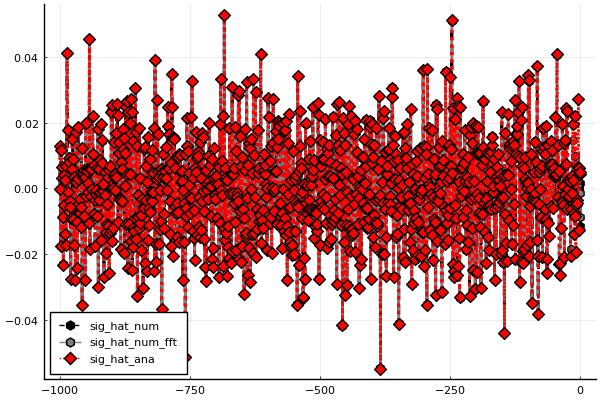

In [19]:
lags = -1000:0
C_ana = crosscov(error_ana,pred,lags)
C_num = crosscov(error_num,pred,lags)
C_num_fft = crosscov(error_num_fft,pred,lags)

print(mean_and_var(C_num),'\n')
print(mean_and_var(C_num_fft),'\n')
print(mean_and_var(C_ana))

plot(lags, [C_num C_num_fft C_ana],
    color=[:black :grey :red],
    line=(2,[:dash :dashdot :dot]),
    label=["sig_hat_num" "sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :hex :d],6))

In [21]:
Nex = 1000;
Theta = 2*pi*(0:Nex - 1)/Nex
Z = exp.(im*Theta);

S_sig_hat_num = z_crossspect(sig_hat_num,sig_hat_num,70; win = "Bart")

H(z) = sum([h_ana[i+1]*z^(-i) for i = 0 : M_h-1]);
S_pred(z) = (conj(r1*r2)*rho_poly(z)/z^2)/((1-r1*z^(-1))*(1-r2*z^(-1))*(1-conj(r1)*z)*(1-conj(r2)*z));
S_sig_hat_ana(z) = H(z)*S_pred(z)*conj(H(conj(z)^(-1)));

plot(Theta,[real.(S_sig_hat_num.(Z)) real.(S_sig_hat_ana.(Z))],
    color=[:black :red],line=(2,[:dash :dot]),label=["S_sig_hat_num" "S_sig_hat_ana"])

LoadError: UndefVarError: z_crossspect not defined